import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## AI in trading
In this final section, I will explore the role of artificial intelligence (AI) in developing effective trading algorithms. So far, we have focused on traditional approaches such as momentum strategies and mean-reversion, where we applied concepts from physics, including the harmonic oscillator and stochastic differential equations. While these methods are grounded in theory, they rely heavily on assumptions—about market efficiency, distribution of returns, or stationarity—that may not always hold true in real-world financial data. These assumptions can introduce significant limitations and potential sources of error.

In contrast, machine learning models can learn patterns directly from data without relying on rigid predefined assumptions. This data-driven approach allows for greater flexibility and adaptability, making AI a powerful tool for uncovering complex, non-linear relationships in financial markets that traditional models might miss.


## Data prep and feature engineering
Before training any machine learning model, careful data preparation and feature engineering are essential. In the context of trading, raw price data alone is often insufficient. Instead, we derive a variety of features that may capture underlying market dynamics. These include technical indicators such as moving averages, momentum, relative strength index (RSI), Bollinger bands, and volatility measures. The goal is to provide the model with inputs that reflect both short-term and long-term behavior of the asset. To avoid look-ahead bias, all features are computed using only past and present data available at the time of prediction. The data is then standardized to ensure that all features are on comparable scales, which helps neural networks converge more efficiently during training. Additionally, time-series data is split using walk-forward validation rather than random sampling, to better simulate real-world trading conditions and prevent data leakage.

## Bulding a classification model
I will begin by building a classification modlel deciding if the price is going to go up or down on the next day.

In [19]:

ticker = 'AAPL'
df = yf.download(ticker, start='2010-01-01', end='2023-12-31')
df = df[['Close']]

C:\Users\mitko\AppData\Local\Temp\ipykernel_23148\1431467168.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2010-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


After getting the data we need to engineer our features

In [21]:

# 2. Feature engineering
df['Return'] = df['Close'].pct_change()
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['Volatility_10'] = df['Close'].rolling(window=10).std()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['Close'])

Now we need to define a target to train our neural network, drop all NaN values and define our features, scaling them.

In [ ]:
# 3. Target: 1 if next day's close > today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# 4. Drop NaNs
df.dropna(inplace=True)

# 5. Features and scaling
features = ['Return', 'MA_5', 'Volatility_10', 'RSI_14']
X = df[features].values
y = df['Target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Now we need to create sequences for our LSTM neural network since it works with them.

In [22]:

def create_sequences(X, y, seq_length=10):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        x_seq = X[i:i+seq_length]
        y_seq = y[i+seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 10
X_seq, y_seq = create_sequences(X_scaled, y, seq_length)

Now we need a train test split and to convert what we have to tensors

In [23]:
# 7. Train-test split (time based)
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# 8. Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [24]:

# 9. DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) 

# 10. LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the output of the last time step
        out = self.fc(out)
        return out

model = LSTMClassifier(input_size=len(features))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 11. Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_preds = (val_outputs > 0.5).float()
        val_acc = (val_preds == y_test_tensor).float().mean().item()

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 12. Final test accuracy
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()
    test_acc = (test_preds == y_test_tensor).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/30 | Train Loss: 0.6928, Train Acc: 0.5055 | Val Loss: 0.6916, Val Acc: 0.5257
Epoch 5/30 | Train Loss: 0.6905, Train Acc: 0.5380 | Val Loss: 0.6990, Val Acc: 0.5014
Epoch 10/30 | Train Loss: 0.6887, Train Acc: 0.5395 | Val Loss: 0.7070, Val Acc: 0.5100
Epoch 15/30 | Train Loss: 0.6864, Train Acc: 0.5352 | Val Loss: 0.7021, Val Acc: 0.5300
Epoch 20/30 | Train Loss: 0.6831, Train Acc: 0.5402 | Val Loss: 0.7109, Val Acc: 0.5286
Epoch 25/30 | Train Loss: 0.6777, Train Acc: 0.5506 | Val Loss: 0.7547, Val Acc: 0.5329
Epoch 30/30 | Train Loss: 0.6773, Train Acc: 0.5638 | Val Loss: 0.7465, Val Acc: 0.5043
Test Accuracy: 0.5043


After creating the network and evaluating it we find out that the accuracy is no better than a random choice.

Despite our efforts, the AI model failed to consistently predict stock movements with meaningful accuracy. This outcome highlights the inherent difficulty of applying machine learning to financial markets. Unlike many other domains, markets are highly noisy, non-stationary, and influenced by countless external, often unpredictable, factors. Even sophisticated models like LSTMs struggle because patterns in financial data are weak, unstable, and can change over time(regime shifts). Additionally, the historical data we use may contain biases or may simply not carry enough predictive signal. Without access to high-quality, diverse data and advanced techniques like ensemble learning, feature selection, or reinforcement learning, building a reliable trading AI is extremely challenging. This failure is not just due to the model or features but reflects a deeper truth: financial prediction is one of the hardest real-world tasks in AI.


## Applying unsupervised learning methods for financial data analysis
In this part I am going to try and implement a well-know unsupervised machine learnign technique - **Principal component anaysis** for dimensionality reduction. I will try and analyze the daily returns of some tech stocks, identifying the **main sources of variation** in the data. , PCA helps identify the main sources of variation in the data. Each principal component represents a latent factor that explains a portion of the overall market behavior, allowing us to summarize complex relationships between assets into a few interpretable components. 

For the sake of this we will:
- download data
- extract ```adj close```
- calculate the returns
- standardize the returns
- apply PCA
- plot the cumulative explained variance
- show how the principal components contribute

[*********************100%***********************]  5 of 5 completed


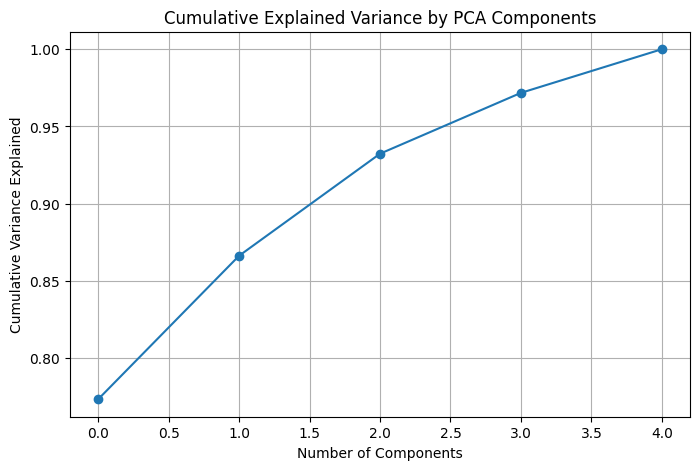

Principal Components (Eigenvectors):
Ticker      AAPL      AMZN     GOOGL      META      MSFT
0       0.454974  0.435318  0.470878  0.400465  0.470530
1      -0.340322 -0.091541 -0.079347  0.893376 -0.267180
2      -0.325011  0.890160 -0.248164 -0.105757 -0.170922
3       0.735200  0.063692 -0.583549  0.142830 -0.307400
4      -0.176151 -0.075354 -0.608164  0.099612  0.763876


In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tickers = ['MSFT', 'AAPL', 'GOOGL', 'AMZN', 'META']

data = yf.download(tickers, start="2022-01-01", end="2023-01-01", auto_adjust=False)

adj_close = data['Adj Close']

returns = adj_close.pct_change().dropna()

returns_scaled = (returns - returns.mean()) / returns.std()

pca = PCA()
pca.fit(returns_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

components_df = pd.DataFrame(pca.components_, columns=returns.columns)
print("Principal Components (Eigenvectors):")
print(components_df)


What do we see here?
The cumulative variance graph shows us how much of the overall variation in the data is captured by each principal component. As we can see, the first component explains the majority of the variance - over 70% - meaning that most of the movement across these stocks can be described by this single factor. The remaining components each explain a smaller portion, with rapidly diminishing contribution.

Next, let’s look at the principal components table, which shows how each stock contributes to each component. These are essentially the directions in the data that capture the most variation, and each row is a new axis - a linear combination of the original stocks.

- In the first component, all five stocks - AAPL, AMZN, GOOGL, META, and MSFT - have similar positive weights. This suggests that this component captures the overall market or tech-sector trend, since all stocks tend to move in the same direction here.
- In the second component, META has a very high loading (about 0.89), while the others are close to zero or negative. This implies that this component is largely driven by META-specific behavior, such as volatility or unique events that affected only Meta during this time period.
- The third component is dominated by Amazon (AMZN), indicating another stock-specific factor.
- In the later components, we start seeing more contrasting behavior. For example, the fourth component shows a strong positive contribution from Apple and a strong negative one from Google, meaning it captures scenarios where those two stocks diverge in price movement

## Resources
- https://builtin.com/artificial-intelligence/ai-trading-stock-market-tech#:~:text=AI%20stock%20trading%20uses%20machine%20learning%2C%20sentiment%20analysis,efficiency%20to%20mitigate%20risks%20and%20provide%20higher%20returns.
- https://www.sciencedirect.com/science/article/pii/S2772662221000102#:~:text=The%20stock%20market%20is%20turbulent%2C%20yet%20using%20artificial,as%20predictive%20analytics%20tools%20in%20the%20stock%20market.